In [6]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
ds = xr.open_dataset('sea_temperature_water_velocity.nc') 
print(ds)

<xarray.Dataset> Size: 177kB
Dimensions:      (time: 4018, depth: 3, latitude: 1, longitude: 1)
Coordinates:
  * depth        (depth) float32 12B 0.5058 1.556 2.668
  * latitude     (latitude) float32 4B 35.25
  * time         (time) datetime64[ns] 32kB 2000-01-01 2000-01-02 ... 2010-12-31
  * longitude    (longitude) float32 4B 121.8
Data variables:
    uo_cglo      (time, depth, latitude, longitude) float32 48kB ...
    thetao_cglo  (time, depth, latitude, longitude) float32 48kB ...
    vo_cglo      (time, depth, latitude, longitude) float32 48kB ...
Attributes: (12/17)
    product:                       GLOBAL_REANALYSIS_PHY_001_031
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    area:                          Global
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    credit:                        E.U. Copernicus Marine Service Information...
    ...                     

In [7]:
print("Variables:", ds.variables.keys())

Variables: KeysView(Frozen({'uo_cglo': <xarray.Variable (time: 4018, depth: 3, latitude: 1, longitude: 1)> Size: 48kB
[12054 values with dtype=float32]
Attributes:
    long_name:      Eastward velocity
    standard_name:  eastward_sea_water_velocity
    units:          m s-1
    unit_long:      Meters per second
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288], 'depth': <xarray.IndexVariable 'depth' (depth: 3)> Size: 12B
array([0.50576 , 1.555855, 2.667682], dtype=float32)
Attributes:
    valid_min:               0.50576
    valid_max:               2.667682
    units:                   m
    positive:                down
    unit_long:               Meters
    long_name:               Depth
    standard_name:           depth
    axis:                    Z
    _ChunkSizes:             75
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 1)> Size: 4B
array([35.25], dtype=float32)
Attributes:

In [20]:



# 时间维度长度即样本数
n_times = ds.dims["time"]
# 如果把每个 time–depth–lat–lon 组合都看作一个样本，则总样本数为：
n_total = ds.dims["time"] * ds.dims["depth"] * ds.dims["latitude"] * ds.dims["longitude"]

# 时间范围
t0 = pd.to_datetime(ds["time"].values[0])
t1 = pd.to_datetime(ds["time"].values[-1])
span_days = (t1 - t0).days

print(f"时间步数（样本数）：{n_times}")
print(f"若按体素计：{n_total} 个样本点")
print(f"时间范围：{t0.date()} 至 {t1.date()}（共 {span_days} 天）")


时间步数（样本数）：4018
若按体素计：12054 个样本点
时间范围：2000-01-01 至 2010-12-31（共 4017 天）


C:\Users\86137\AppData\Local\Temp\ipykernel_30472\4110843061.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims["time"]
C:\Users\86137\AppData\Local\Temp\ipykernel_30472\4110843061.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_total = ds.dims["time"] * ds.dims["depth"] * ds.dims["latitude"] * ds.dims["longitude"]


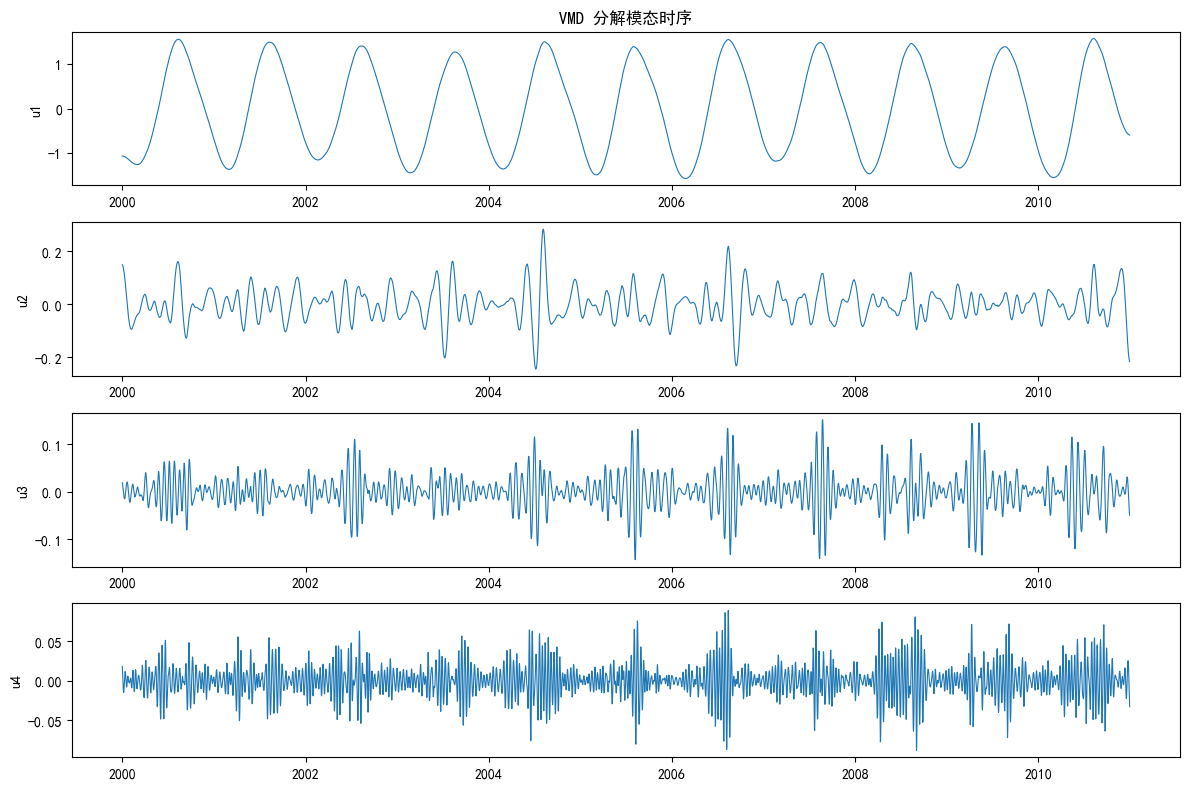

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

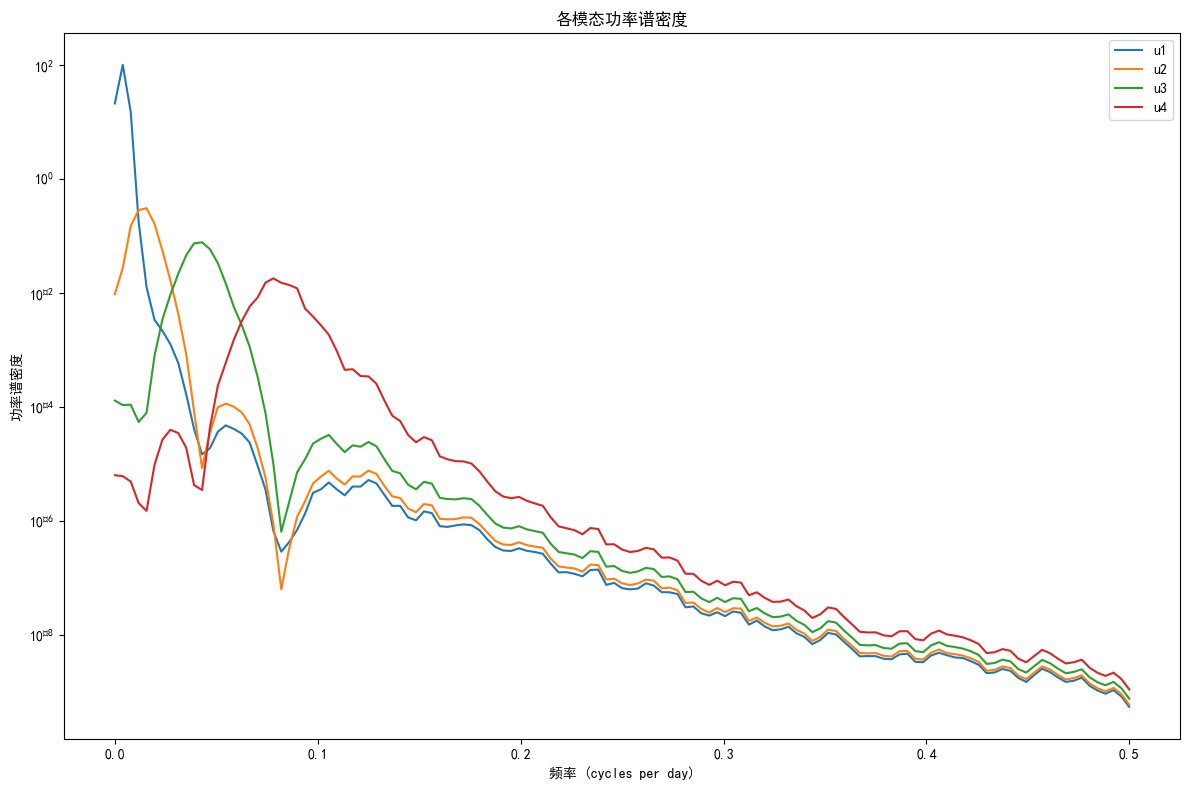

In [23]:
from scipy.signal import welch
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 选择最浅层海温序列（depth 索引 0），单点提取
thetao = ds['thetao_cglo'].sel(depth=ds.depth[0], latitude=ds.latitude[0], longitude=ds.longitude[0])
# 转为 numpy 数组
ts = thetao.values
# 时间轴
time = pd.to_datetime(ds['time'].values)

# 归一化
ts_mean = np.mean(ts)
ts_std = np.std(ts)
x = (ts - ts_mean) / ts_std

# 2. VMD 分解参数设置
alpha = 2000      # 惩罚因子
tau = 0.          # 噪声容忍度
K = 4             # 模态数量
DC = False        # 是否保留直流分量
init = 1          # 初始化方式（1: 随机）
tol = 1e-6        # 收敛阈值

# 3. 执行 VMD
u, u_hat, omega = VMD(x, alpha, tau, K, DC, init, tol)
# u.shape == (K, N)

# 4. 可视化：模态时序
plt.figure(figsize=(12, 8))
for k in range(K):
    plt.subplot(K, 1, k+1)
    plt.plot(time, u[k], lw=0.8)
    plt.ylabel(f'u{k+1}')
    if k == 0:
        plt.title('VMD 分解模态时序')
plt.tight_layout()
plt.show()

# 5. 功率谱密度分析 (Welch 方法)
plt.figure(figsize=(12, 8))
for k in range(K):
    f, Pxx = welch(u[k], fs=1.0, nperseg=256)
    plt.semilogy(f, Pxx, label=f'u{k+1}')
plt.xlabel('频率 (cycles per day)')
plt.ylabel('功率谱密度')
plt.title('各模态功率谱密度')
plt.legend()
plt.tight_layout()
plt.show()

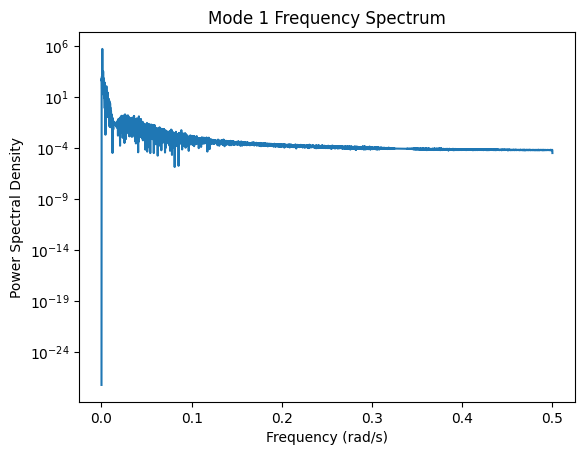

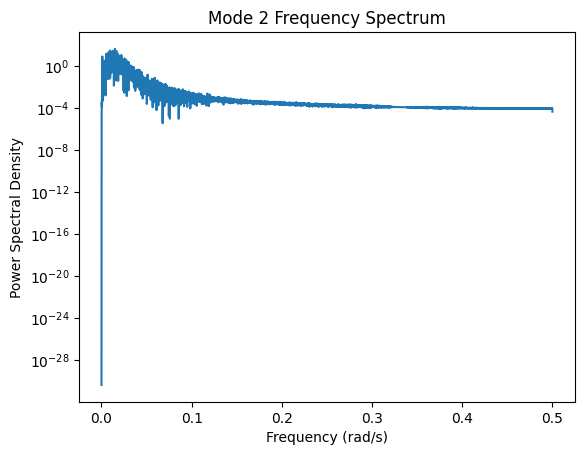

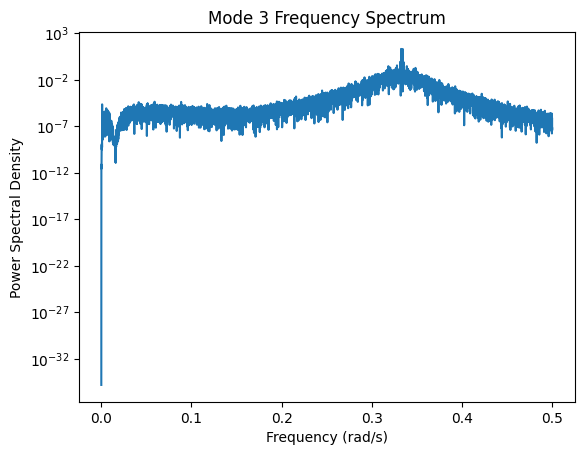